# Bayesian prediction of Brownian particle motion

Procedure for generating the trajectories of Brownian particle is based on the [Nature paper](https://nature.com/articles/s41567-020-1018-2) and the authors' code.

In [1]:
from typing import Optional, List, Iterable, Tuple
import functools
import os

import matplotlib.pyplot as plt
import numpy as np
import torch

import numpy.typing
NDArray = numpy.typing.NDArray[np.floating]

In [2]:
from brownian_datagen import BrownianDatagen
from bayesian import (posterior_predictive_forward_and_backward, ExperimentResults,
                      BayesTrainData, plot_predictions, quality_metrics)
from datasets import reverse_windows_targets

(<Figure size 500x1000 with 3 Axes>,
 array([<Axes: title={'center': 'Forward trajectories'}, xlabel='index', ylabel='coordinate of the particle, forward'>,
        <Axes: title={'center': 'Backward trajectories'}, xlabel='index', ylabel='coordinate of the particle, backward'>,
        <Axes: title={'center': 'Work distributions'}>], dtype=object))

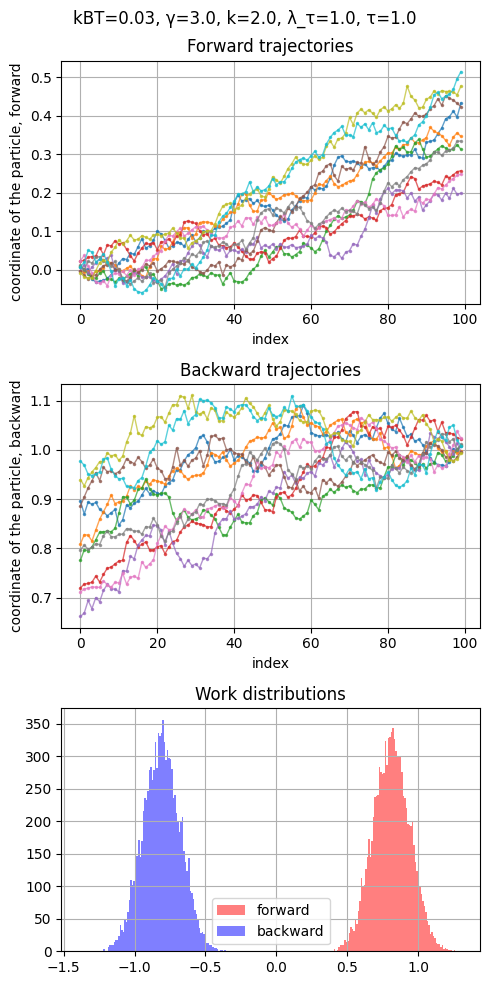

In [3]:
save_dir = "20230724_preds/brownian01/"
brownian = BrownianDatagen(kBT=0.03, γ=3., k=2., λ_τ=1., τ=1.)
brownian.visualize()

In [4]:
def create_dataholder_for_windows_and_targets(brownian: BrownianDatagen,
                                              numParticles: int = 50,
                                              window_len: int = 3,
                                              rng_seed: Optional[int] = None) -> BayesTrainData:
    meaningless_time_series = np.zeros((5, 1), np.float32)
    dt = BayesTrainData(meaningless_time_series)
    # For Brownian motion, different windows might come from different
    # trajectories, so having one single time series doesn't make sense.
    # Morover, backward and forward don't refer to the same thing anymore:
    # they are generated separately, rather than backward = np.flip(forward).
    # But I want to keep using the same class for holding the train data, so I set attributes manually.
    generate_windows_targets = functools.partial(brownian.windows_targets, window_len=window_len, numParticles=numParticles)
    if rng_seed is not None:
        generate_windows_targets = functools.partial(generate_windows_targets, rng_seed=rng_seed)
    
    dt.windows_f, dt.targets_f = generate_windows_targets()
    dt.windows_b, dt.targets_b = generate_windows_targets(backward=True)
    dt.windows_f, dt.targets_f, dt.windows_b, dt.targets_b = map(
        lambda x: torch.tensor(x, dtype=torch.float32),
        (dt.windows_f, dt.targets_f, dt.windows_b, dt.targets_b))
    return dt

dt = create_dataholder_for_windows_and_targets(brownian, rng_seed=42)
print(dt.windows_f.shape, dt.targets_f.shape)

torch.Size([4850, 3]) torch.Size([4850, 1])


In [5]:
if not os.path.isdir(save_dir):
    posterior_predictive_forward_and_backward(dt, save_dir=save_dir, num_samples=100)
else:
    print("Directory exists, assuming the previous results are reusable")

Directory exists, assuming the previous results are reusable


In [6]:
!ls $save_dir

noisy_ts.torch		   targets_b.torch  windows_b.torch
predictive.backward.torch  targets_f.torch  windows_f.torch
predictive.forward.torch   ts.torch


In [7]:
er = ExperimentResults(save_dir)
print("forward train:", quality_metrics(er.pred_obs_f, er.targets_f))
print("backward train:", quality_metrics(er.pred_obs_b, er.targets_b))

forward train: {'mae': 0.011382177472114563, 'rmse': 0.011382177472114563, 'crps': 0.00805527251213789, 'mean_std': 0.014099109917879105, 'mse_from_all': 0.00039971532532945275}
backward train: {'mae': 0.011238389648497105, 'rmse': 0.011238389648497105, 'crps': 0.007961885072290897, 'mean_std': 0.013959367759525776, 'mse_from_all': 0.00039116948028095067}


In [8]:
dt_test = create_dataholder_for_windows_and_targets(brownian, numParticles=1, window_len=3, rng_seed=11288)
print("forward test", quality_metrics(er.predictive_f(dt_test.windows_f)["obs"], dt_test.targets_f))
print("backward test", quality_metrics(er.predictive_b(dt_test.windows_b)["obs"], dt_test.targets_b))

forward test {'mae': 0.013421513140201569, 'rmse': 0.013421513140201569, 'crps': 0.009518520906567574, 'mean_std': 0.014035332947969437, 'mse_from_all': 0.0004643647698685527}
backward test {'mae': 0.02309475652873516, 'rmse': 0.02309475652873516, 'crps': 0.018338419497013092, 'mean_std': 0.015356347896158695, 'mse_from_all': 0.0032351284753531218}


torch.Size([97]) torch.Size([97])


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Forward'}, xlabel='index', ylabel='target value'>)

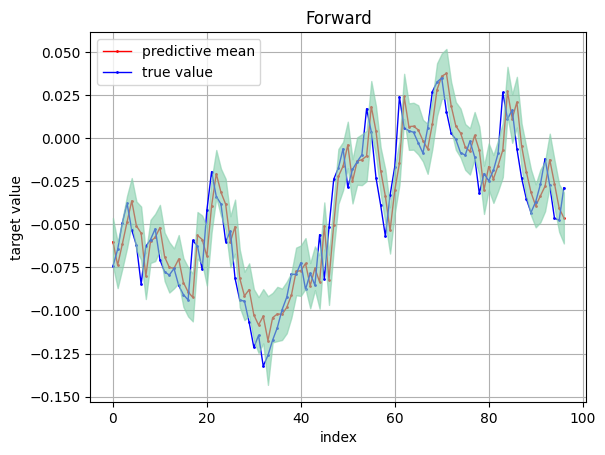

In [9]:
plot_predictions(true=dt_test.targets_f,
                 pred_mean=er.predictive_f(dt_test.windows_f)["obs"].mean(axis=0),
                 pred_std=er.predictive_f(dt_test.windows_f)["obs"].std(axis=0),
                 title="Forward")

torch.Size([97]) torch.Size([97])


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Backward'}, xlabel='index', ylabel='target value'>)

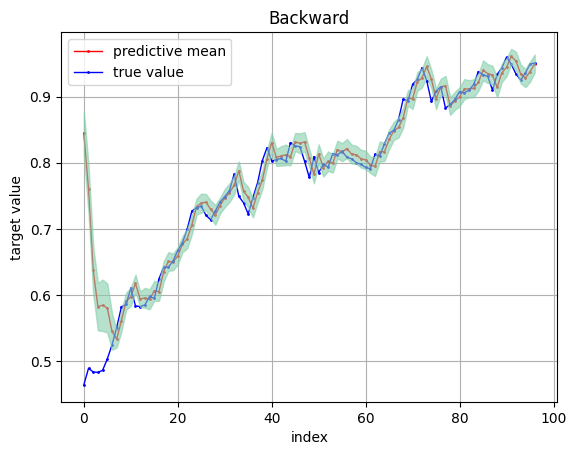

In [10]:
plot_predictions(true=dt_test.targets_b,
                 pred_mean=er.predictive_b(dt_test.windows_b)["obs"].mean(axis=0),
                 pred_std=er.predictive_b(dt_test.windows_b)["obs"].std(axis=0),
                 title="Backward")

## Forward-backward terminology above was from the Nature paper. Let's now simply `np.flip` the forward trajectories and compare forward-backward in the probabilistic sense.

In [11]:
save_dir = "20230724_preds/brownian01_probabilistic/"

In [12]:
def reverse_windows_targets_squeezed(windows: NDArray, targets: NDArray) -> Tuple[NDArray, NDArray]:
    def unsqueeze(arr: NDArray) -> NDArray:
        return arr.reshape(*arr.shape, 1)

    windows, targets = reverse_windows_targets(unsqueeze(windows), unsqueeze(targets))
    return windows.squeeze(-1), targets.squeeze(-1)

def create_simple_flip_dataholder_for_windows_and_targets(
        brownian: BrownianDatagen,
        numParticles: int = 50,
        window_len: int = 3,
        rng_seed: Optional[int] = None) -> BayesTrainData:
    meaningless_time_series = np.zeros((5, 1), np.float32)
    dt = BayesTrainData(meaningless_time_series)
    # For Brownian motion, different windows might come from different
    # trajectories, so having one single time series doesn't make sense.
    # But I want to keep using the same class for holding the train data, so I set attributes manually.
    generate_windows_targets = functools.partial(brownian.windows_targets, window_len=window_len, numParticles=numParticles)
    if rng_seed is not None:
        generate_windows_targets = functools.partial(generate_windows_targets, rng_seed=rng_seed)
    
    dt.windows_f, dt.targets_f = generate_windows_targets()
    dt.windows_b, dt.targets_b = reverse_windows_targets_squeezed(dt.windows_f, dt.targets_f)
    
    dt.windows_f, dt.targets_f, dt.windows_b, dt.targets_b = map(
        lambda x: torch.tensor(x, dtype=torch.float32),
        (dt.windows_f, dt.targets_f, dt.windows_b, dt.targets_b))
    
    return dt

dt = create_simple_flip_dataholder_for_windows_and_targets(brownian, rng_seed=42)
print(dt.windows_f.shape, dt.targets_f.shape)
dt_test = create_simple_flip_dataholder_for_windows_and_targets(brownian, numParticles=1, rng_seed=4125)

torch.Size([4850, 3]) torch.Size([4850, 1])


In [13]:
if not os.path.isdir(save_dir):
    posterior_predictive_forward_and_backward(dt, save_dir=save_dir, num_samples=100)
else:
    print("Directory exists, assuming the previous results are reusable")

Sample: 100%|██| 200/200 [09:32,  2.86s/it, step size=1.00e-04, acc. prob=0.970]


In [14]:
er = ExperimentResults(save_dir)
print("forward train:", quality_metrics(er.pred_obs_f, er.targets_f))
print("backward train:", quality_metrics(er.pred_obs_b, er.targets_b))
print("forward test", quality_metrics(er.predictive_f(dt_test.windows_f)["obs"], dt_test.targets_f))
print("backward test", quality_metrics(er.predictive_b(dt_test.windows_b)["obs"], dt_test.targets_b))

forward train: {'mae': 0.011381431482732296, 'rmse': 0.011381431482732296, 'crps': 0.008044742047786713, 'mean_std': 0.014079488813877106, 'mse_from_all': 0.00039878342067822814}
backward train: {'mae': 0.01119418628513813, 'rmse': 0.01119418628513813, 'crps': 0.007941015064716339, 'mean_std': 0.01392781175673008, 'mse_from_all': 0.0003896463313139975}
forward test {'mae': 0.010884957388043404, 'rmse': 0.010884957388043404, 'crps': 0.007704050745815039, 'mean_std': 0.014207141473889351, 'mse_from_all': 0.00038344829226844013}
backward test {'mae': 0.010960305109620094, 'rmse': 0.010960305109620094, 'crps': 0.00793954823166132, 'mean_std': 0.013934011571109295, 'mse_from_all': 0.0003923519980162382}


torch.Size([97]) torch.Size([97])
torch.Size([97]) torch.Size([97])


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Backward'}, xlabel='index', ylabel='target value'>)

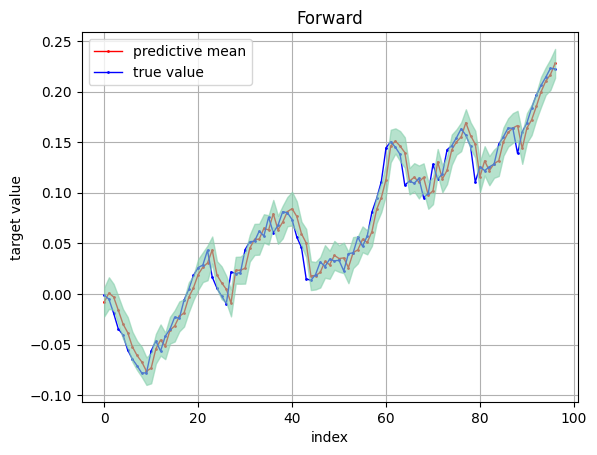

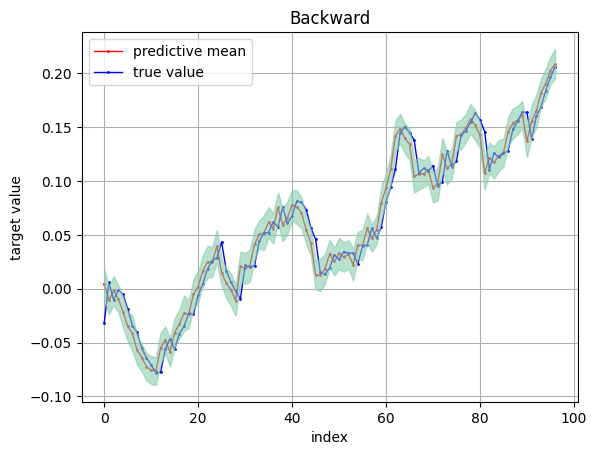

In [15]:
plot_predictions(true=dt_test.targets_f,
                 pred_mean=er.predictive_f(dt_test.windows_f)["obs"].mean(axis=0),
                 pred_std=er.predictive_f(dt_test.windows_f)["obs"].std(axis=0),
                 title="Forward")
plot_predictions(true=dt_test.targets_b,
                 pred_mean=er.predictive_b(dt_test.windows_b)["obs"].mean(axis=0),
                 pred_std=er.predictive_b(dt_test.windows_b)["obs"].std(axis=0),
                 title="Backward")